<a href="https://colab.research.google.com/github/Sunnnyyy16/Dacon_study/blob/main/bike/seoul_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 서울시 따릉이 대여량 예측 경진대회
사이트: https://dacon.io/competitions/open/235576/overview/description

# 목차
1. 데이터 EDA
2. 데이터 전처리
3. 모델링
4. 결론

참고

https://dacon.io/competitions/open/235576/codeshare/617?page=1&dtype=recent

# 데이터 로드

서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!cp /gdrive/MyDrive/Dacon_study/bike/submission.csv ./
!cp /gdrive/MyDrive/Dacon_study/bike/test.csv ./
!cp /gdrive/MyDrive/Dacon_study/bike/train.csv ./

In [ ]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
submission=pd.read_csv('submission.csv')

In [ ]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


* id : 고유 id
* hour : 시간
* hour_bef_temperature : 기온
* hour_bef_precipitation : 비 오지 않았으면 0, 비 오면 1
* hour_bef_windspeed : 풍속(평균)
* hour_bef_humidity : 습도
* hour_bef_visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* hour_bef_ozone : 오존
* hour_bef_pm10 : 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* hour_bef_pm2.5 : 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

In [ ]:
train['hour'].value_counts()

20    61
4     61
5     61
11    61
22    61
19    61
15    61
7     61
8     61
10    61
1     61
14    61
9     61
3     61
2     61
18    61
23    61
6     61
12    61
13    60
17    60
16    60
0     60
21    60
Name: hour, dtype: int64

날짜가 없고 시간만 있어서 정확한 EDA 및 분석이 어려울 것 같다.

## null값 확인

In [ ]:
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

null값 존재 --> 처리 필요

In [ ]:
test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

null값 존재 --> 처리 필요

## null값 처리

In [ ]:
train['hour_bef_temperature'] =train['hour_bef_temperature'].fillna(value=train['hour_bef_temperature'].mean())
train['hour_bef_precipitation'] =train['hour_bef_precipitation'].fillna(value=train['hour_bef_precipitation'].mean())
train['hour_bef_windspeed'] =train['hour_bef_windspeed'].fillna(value=train['hour_bef_windspeed'].mean())
train['hour_bef_humidity'] =train['hour_bef_humidity'].fillna(value=train['hour_bef_humidity'].mean())
train['hour_bef_visibility'] =train['hour_bef_visibility'].fillna(value=train['hour_bef_visibility'].mean())
train['hour_bef_ozone'] =train['hour_bef_ozone'].fillna(value=train['hour_bef_ozone'].mean())
train['hour_bef_pm10'] =train['hour_bef_pm10'].fillna(value=train['hour_bef_pm10'].mean())
train['hour_bef_pm2.5'] =train['hour_bef_pm2.5'].fillna(value=train['hour_bef_pm2.5'].mean())

# 01.데이터 EDA

In [ ]:
# 시간대별 자전거 대여량
train.groupby(['hour'])['count'].mean().to_frame().reset_index()

,hour,count
0,0,71.766667
1,1,47.606557
2,2,31.409836
3,3,21.377049
4,4,13.524590
5,5,13.114754
6,6,24.557377
7,7,62.360656
8,8,136.688525
9,9,93.540984


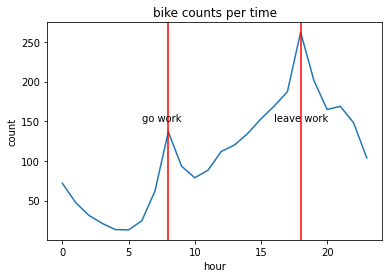

In [ ]:
plt.figure()
sns.lineplot(x='hour', y='count', data=train.groupby(['hour'])['count'].mean().to_frame().reset_index())
plt.axvline(x=8,color='r')
plt.axvline(x=18,color='r')
plt.text(6,150, 'go work')
plt.text(16,150, 'leave work')
plt.title('bike counts per time')
plt.show()